# DATA C200 Grad Project

We have chosen to work with Topic 3, Dataset A. The dataset contains reports from researches of outer space, more specifically topics sush as habitable planets. 
By analyzing this dataset, we want to research whether or not there are any patterns in where habitable exoplanets appear. To do so we will use the features of nearby planets as our features. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
koi = pd.read_csv('../data/cumulative_2022.10.18_16.13.29.csv', skiprows=53)
pscd = pd.read_csv('../data/PSCompPars_2022.10.18_16.13.33.csv', skiprows=88)

## Sampling & Collection

The reports that we use are kepler_exoplanet_search and kepler_planetary_system_composite which are both collected by NASA from the Kepler Space Observatory. 

Habitable planets are defined by these requirements:
- Mass: 0.1-10 EM
- Radius: 0.5-2.5 Earth radius
- Eq Temp: 175-270 Kelvin

Let's concentrate on the overlap between the two reports with special emphasis on the planets meeting the requirements above. 

In [3]:
temp_min, temp_max = 175, 270
mass_min, mass_max = 1, 10
radius_min, radius_max = 0.5, 2.5

def get_habitable_mask(data, mass_col=None, radius_col=None, temp_col=None):
    mass_mask = True
    if mass_col:
        mass_mask = (data[mass_col] >= 0.1) & (data[mass_col] - 1<= 10)
        print(f'Mass match: {len(data[mass_mask]) / len(data) * 100:.2f}%')

    radius_mask = True
    if radius_col:
        radius_mask = (data[radius_col] >= 0.5) & (data[radius_col] <= 2.5)
        print(f'Radius match: {len(data[radius_mask]) / len(data) * 100:.2f}%')

    temp_mask = True
    if temp_col:
        temp_mask = (data[temp_col] >= 182) & (data[temp_col] <= 285)
        print(f'Temp match: {len(data[temp_mask]) / len(data) * 100:.2f}%')
    
    return mass_mask & radius_mask & temp_mask

def find_habitable(data, mass_col=None, radius_col=None, temp_col=None):
    habitable =  data[get_habitable_mask(data, mass_col, radius_col, temp_col)]
    print(f'{len(habitable)} total habitable planets found')

    return habitable

Radius match: 49.41%
Temp match: 6.40%
372
Mass match: 56.87%
Radius match: 44.05%
Temp match: 1.52%


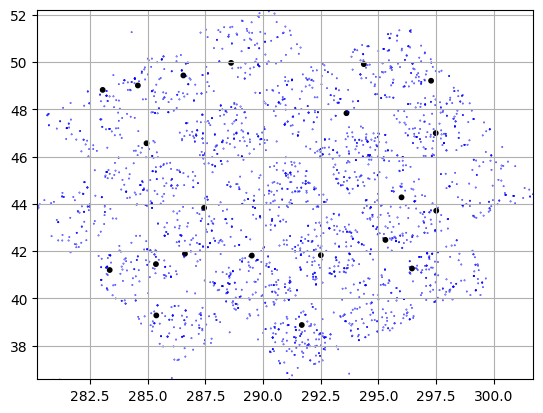

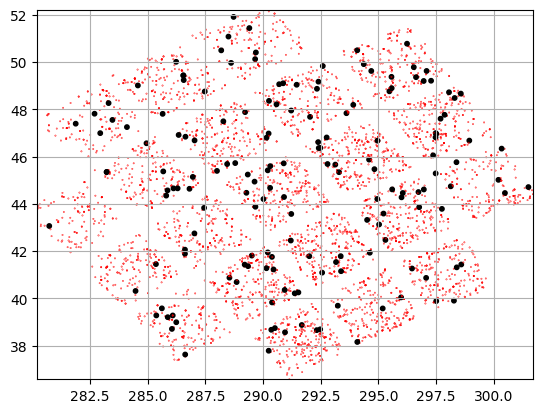

In [4]:
cols = ['ra', 'dec']

koi_habitable_mask = get_habitable_mask(koi, radius_col='koi_prad', temp_col='koi_teq')
print(koi_habitable_mask.sum())
koi_pos = koi[koi['koi_disposition'].isin(['CONFIRMED', 'CANDIDATE'])][cols]
koi_pos['type'] = 'KOI'
koi_pos['type'][koi_habitable_mask] = 'Habitable'

pcsd_habitable_mask = get_habitable_mask(pscd, mass_col='pl_bmasse', radius_col='pl_rade', temp_col='pl_eqt')
pscd_pos = pscd[cols]
pscd_pos['type'] = 'PSCD'
pscd_pos['type'][pcsd_habitable_mask] = 'Habitable'

k_ra_lim = (koi_pos['ra'].min(), koi_pos['ra'].max())
k_dec_lim = (koi_pos['dec'].min(), koi_pos['dec'].max())

colors = {'KOI': 'Red', 'PSCD': 'Blue', 'Habitable': 'Black'}
default_size = .1
sizes = {'KOI': default_size, 'PSCD': default_size, 'Habitable': 10}

plt.xlim(k_ra_lim)
plt.ylim(k_dec_lim)
plt.grid(True)
plt.scatter(pscd_pos['ra'], pscd_pos['dec'], c=pscd_pos['type'].map(colors), s=pscd_pos['type'].map(sizes))
plt.show()

plt.xlim(k_ra_lim)
plt.ylim(k_dec_lim)
plt.grid(True)
plt.scatter(koi_pos['ra'], koi_pos['dec'], c=koi_pos['type'].map(colors), s=koi_pos['type'].map(sizes))
plt.show()

Above we have plotted the objects in both datasets within the region of the sky captured by the Kepler telescope. As we can see, there is significant bias in where we have data and not. 

1. We only have data where the light hit the sensors on the Kepler telescope. Thus, we can clearly see the outline of the lense. 
2. Several of the lenses of the Kepler telescope have failed over time, so no new data is gathered from them.

In addition, there is bias introduced by the specifics of the Kepler telescope.
1. The specifics of the lense used for the Kepler telescope also biases the findings, as some habitable exoplanets that don't cause enough of a change in light will not picked up.
2. The telescope has only been running for 9 years, so any planet that has not passed before its sun in that time will not be picked up.

## Cleaning

In [5]:
from sklearn.preprocessing import FunctionTransformer

Clean data is data that satisfies the following conditions

1. No null values
2. No erroneous outliers
3. Accurate values

For each of these steps, let's create a series of sklearn transformers that clean each of our datasets. We'll keep track of these transformers in pipelines which we can run over our whole dataset. 

In [6]:
koi_pipeline = []
pscd_pipeline = []

### KOI

There's no need in looking at the metadata for this analysis. This includes all columns measuring the measurement error of data, ie. columns with the `_err` suffix.

In [7]:
data_cols = koi.columns.to_numpy()[~koi.columns.str.contains('_err')]
koi_data = koi[data_cols] 

#### NULL Values

Let's define a function that gives us the number of null values in each column of a dataframe

In [8]:
def num_nulls_in_cols(df):
    df = pd.DataFrame(df.isna().sum(), columns=['# NULLs'])
    return df[df['# NULLs'] > 0]

In [9]:
na_df = num_nulls_in_cols(koi_data)
na_df

,# NULLs
kepler_name,6891
koi_score,1510
koi_impact,363
koi_depth,363
koi_prad,363
koi_teq,363
koi_insol,321
koi_model_snr,363
koi_tce_plnt_num,346
koi_tce_delivname,346


We see that `kepler_name` contains a large number of null values. We don't care about the name, as this has not bearing on our research question.

In [10]:
problematic_cols = na_df[na_df['# NULLs'] > 0].index.to_numpy()
problematic_cols = np.delete(problematic_cols, 0) # Remove 'kepler_name'
koi_problematic = koi_data[problematic_cols]

Further, note that there are many columns with the same amount of NULL values. Are these all from the same row?

In [11]:
num_nulls_in_cols(koi_problematic[koi_problematic['koi_impact'].isna()])

,# NULLs
koi_score,304
koi_impact,363
koi_depth,363
koi_prad,363
koi_teq,363
koi_insol,321
koi_model_snr,363
koi_tce_plnt_num,91
koi_tce_delivname,91
koi_steff,363


As these rows are missing a large number of important values, there is no use in keeping them.

In [12]:
koi_c1 = koi_data[~koi_data['koi_impact'].isna()]
num_nulls_in_cols(koi_c1[problematic_cols])

,# NULLs
koi_score,1206
koi_tce_plnt_num,255
koi_tce_delivname,255
koi_kepmag,1


There are two remaining columns with the same amount of NULL values. From the data definition these are
- `koi_tce_plnt_num`:   TCE Planet Number federated to the KOI.
- `koi_tce_delivname`:  TCE delivery name corresponding to the TCE data federated to the KOI.

Both of these are names and can safely be dropped.

In [14]:
koi_c2 = koi_c1[~koi_c1['koi_tce_plnt_num'].isna()]
num_nulls_in_cols(koi_c2[problematic_cols])

,# NULLs
koi_score,951
koi_kepmag,1


There's still a large number of objects without a `koi_score`. Are those rows different from the rest of the dataset?

In [15]:
na_mean = pd.DataFrame(koi_c2[data_cols][koi_c2['koi_score'].isna()].describe().loc['mean'])
proper_mean = pd.DataFrame(koi_c2[data_cols][~koi_c2['koi_score'].isna()].describe().loc['mean'])
pd.concat([na_mean, proper_mean], keys=['NULL', 'Proper'], axis=1)

,NULL,Proper
,mean,mean
kepid,7.653660e+06,7.693599e+06
koi_score,NaN,4.837682e-01
koi_fpflag_nt,3.838065e-01,1.617261e-01
koi_fpflag_ss,5.152471e-02,2.684178e-01
koi_fpflag_co,8.727655e-02,2.215134e-01
koi_fpflag_ec,5.573081e-02,1.352095e-01
koi_period,2.117071e+02,3.711282e+01
koi_time0bk,2.199548e+02,1.576513e+02
koi_impact,1.675782e+00,6.189177e-01


There are large discrepancies in all the `koi_fpflag` columns. From the NASA website, we see that these columns indicate an object that might be the result of sensor or other noise. As we don't want this erroneous data, we remove it as well.

In [ ]:
koi_c3 = koi_c2[~koi_c2['koi_score'].isna()]
num_nulls_in_cols(koi_c3)

,# NULLs
kepler_name,5340
koi_kepmag,1


There is still one NA value in the `koi_kepmag` column. 

In [51]:
koi_c3[koi_c3['koi_kepmag'].isna()]

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
7996,2438061,K06270.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.0,0,1,0,0,2.442941,132.011468,1.164,4.1847,37338.0,48.18,1352.0,788.17,229.7,1.0,q1_q17_dr25_tce,5780.0,4.438,1.0,290.27701,37.79097,NaN


Since it looks normal, we keep it and fill in its value as the mean.

In [52]:
koi_c4 = koi_c3.copy()
koi_c4['koi_kepmag'] = koi_c4['koi_kepmag'].fillna(koi_c4['koi_kepmag'].mean())

In conclusion, we get these pipeline steps

In [53]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [54]:
class RemoveColumnNULLs:
    def __init__(self, column: str):
        self._column = column

    def __call__(self, df:pd.DataFrame) -> pd.DataFrame:
        return df[df[self._column].notna()]


class PandasImputer(SimpleImputer):
    def __init__(self, missing_values, strategy, columns=None):
        self.columns = columns
        super().__init__(missing_values=missing_values, strategy=strategy)

    def __call__(self, X):
        df = X.copy()
        with_means =  super().fit_transform(X[self.columns])
        df[self.columns] = with_means
        return df

In [55]:
remove_koi_impact_nas = FunctionTransformer(RemoveColumnNULLs('koi_impact'))
remove_tce_plnt_num_nas = FunctionTransformer(RemoveColumnNULLs('koi_tce_plnt_num'))
remove_koi_score_nas = FunctionTransformer(RemoveColumnNULLs('koi_score'))
impute_koi_kepmag_mean =  FunctionTransformer(PandasImputer(columns=['koi_kepmag'], missing_values=np.nan, strategy='mean'))
koi_pipeline.extend([
    ("Remove rows with NULLs in 'koi_impact'", remove_koi_impact_nas),
    ("Remove rows with NULLs in 'koi_tce_plnt_num'", remove_tce_plnt_num_nas),
    ("Remove rows with NULLS in 'koi_score'", remove_koi_score_nas),
    ("Impute means", impute_koi_kepmag_mean)
])

#### Outliers

Let's create box plots in order to look for outliers

In [56]:
import matplotlib.pyplot as plt

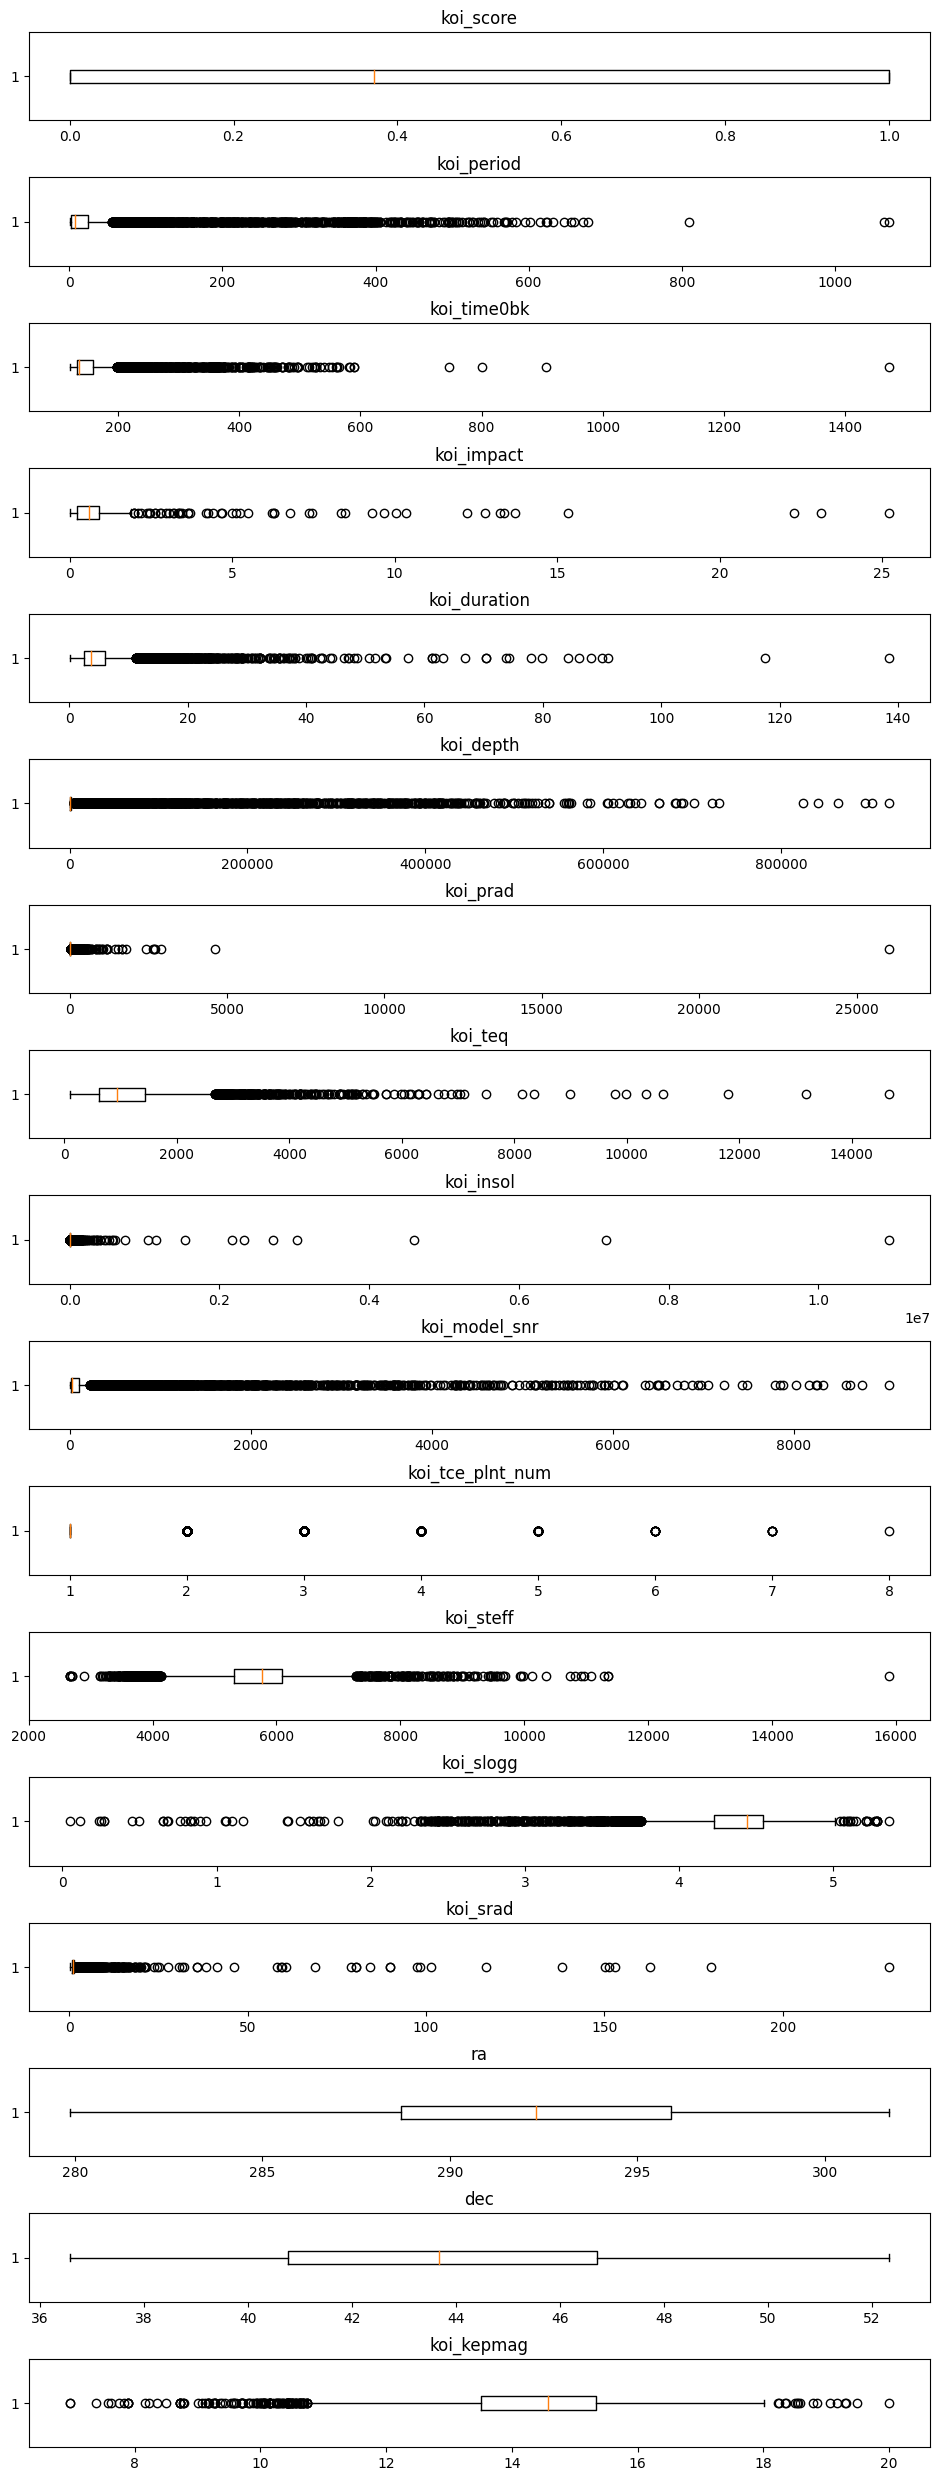

In [57]:
koi_numerical = koi_c4.select_dtypes(exclude=['object', 'int64'])
fig, axs = plt.subplots(nrows=len(koi_numerical.columns), figsize=(10, 25))
fig.tight_layout(pad=2.0)

for i, c in enumerate(koi_numerical.columns):
    axs[i].boxplot(koi_numerical[c], vert=False)
    axs[i].set_title(c)

Some of the distribution values look very skewed. To correct for this, let's replace them with their logs.

In [58]:
skewed_cols = ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_srad']
koi_log = koi_c4.copy()

for c in skewed_cols:
    koi_log[f'{c}_log'] = np.log1p(koi_log[c])

koi_log = koi_log.drop(skewed_cols, axis=1)


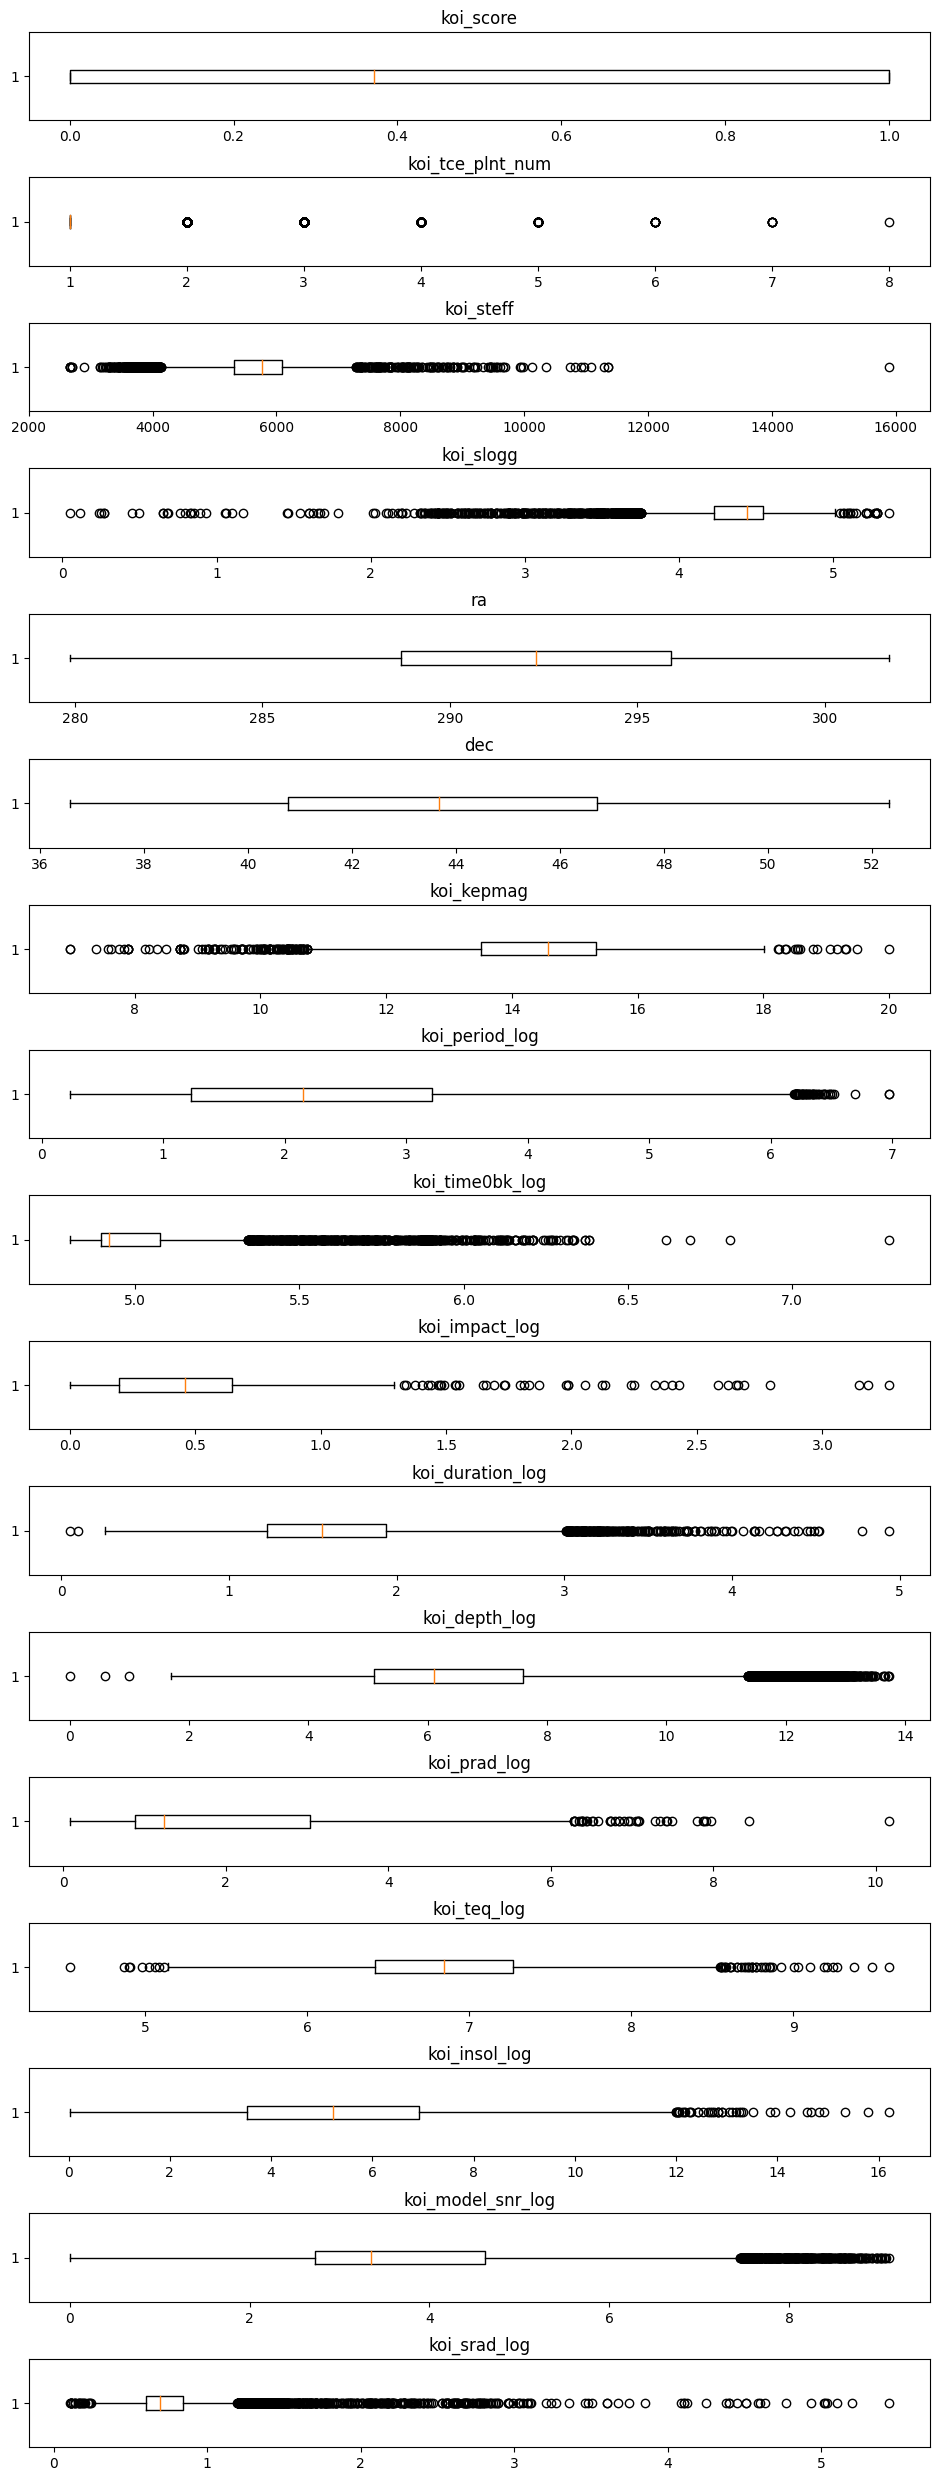

In [59]:
koi_numerical_log = koi_log.select_dtypes(exclude=['object', 'int64'])
fig, axs = plt.subplots(nrows=len(koi_numerical_log.columns), figsize=(10, 25))
fig.tight_layout(pad=2.0)

for i, c in enumerate(koi_numerical_log.columns):
    axs[i].boxplot(koi_numerical_log[c], vert=False)
    axs[i].set_title(c)

Seems like there are a fair number of outliers. Let's remove all rows that have a value that is over 3 standard deviations from the mean.

In [60]:
from scipy import stats

koi_no_outliers = koi_log[(np.abs(stats.zscore(koi_numerical_log)) < 3).all(axis=1)]
print(f'Removed {len(koi_c4) - len(koi_no_outliers)}/{len(koi_c4)} rows')

Removed 902/7995 rows


Lets capture these transformations in our pipeline

In [61]:
class RemoveOutliers:
    def __init__(self, n_std_div, columns=None):
        self._n_std_div = n_std_div
        self.columns = columns

    def __call__(self, df:pd.DataFrame) -> pd.DataFrame:
        return  df[(np.abs(stats.zscore(df[self.columns])) < self._n_std_div).all(axis=1)]

class Log:
    def __init__(self, columns):
        self.columns = columns

    def __call__(self, df:pd.DataFrame) -> pd.DataFrame:
        df1 = df.copy()
        df1[self.columns] = np.log1p(df1[self.columns])
        return df1

In [62]:
log_skewed = FunctionTransformer(Log(skewed_cols))
remove_outliers = FunctionTransformer(RemoveOutliers(3, koi_numerical.columns))

koi_pipeline.extend([
    ("Log", log_skewed),
    ("Remove outliers", remove_outliers)
])

#### Accuracy

The KOI dataset includes information about the accuracy of its columns in the `_err` columns. Lets use this to find rows where we are unsure about the values. Let's define this as any values where the sigma is over 20% of the measured value. 

In [63]:
koi.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'], dtype='object')

In [64]:
uncertain_columns = ['koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad']
koi_accuracy_info = koi[uncertain_columns].fillna(0)

for c in uncertain_columns:
    koi_accuracy_info[f'{c}_sigma'] = koi[f'{c}_err1'] - koi[f'{c}_err2']
    koi_accuracy_info[f'{c}_sigma_percent'] = koi_accuracy_info[f'{c}_sigma'] * 100 / np.maximum(koi_accuracy_info[c], 1)
    print(c)
    print(f'Average sigma: {koi_accuracy_info[f"{c}_sigma_percent"].mean(): .1f}, std: {koi_accuracy_info[f"{c}_sigma_percent"].std(): .1f}')
    print(f'Num rows with sigma percent > 20: {len(koi_accuracy_info[koi_accuracy_info[f"{c}_sigma_percent"] > 20])}')
    print()


koi_period
Average sigma:  0.0, std:  0.0
Num rows with sigma percent > 20: 0

koi_time0bk
Average sigma:  0.0, std:  0.0
Num rows with sigma percent > 20: 0

koi_impact
Average sigma:  179.3, std:  759.1
Num rows with sigma percent > 20: 7643

koi_duration
Average sigma:  13.8, std:  33.5
Num rows with sigma percent > 20: 1911

koi_depth
Average sigma:  16.1, std:  168.5
Num rows with sigma percent > 20: 2276

koi_prad
Average sigma:  37.2, std:  21.3
Num rows with sigma percent > 20: 7239

koi_teq
Average sigma:  nan, std:  nan
Num rows with sigma percent > 20: 0

koi_insol
Average sigma:  101.6, std:  67.2
Num rows with sigma percent > 20: 9049

koi_steff
Average sigma:  5.3, std:  1.6
Num rows with sigma percent > 20: 7

koi_slogg
Average sigma:  6.4, std:  4.9
Num rows with sigma percent > 20: 242

koi_srad
Average sigma:  36.1, std:  21.6
Num rows with sigma percent > 20: 6793



As we can see, many columns are quite uncertain. We don't do anything with this directly, but it is good to keep in mind for later. 

### PSCD

#### NULL Values

In [65]:
data_cols = pscd.columns.to_numpy()[~pscd.columns.str.contains('err') & ~pscd.columns.str.contains('lim')]
pscd_data = pscd[data_cols] 

In [66]:

na_df = num_nulls_in_cols(pscd_data)
na_df

,# NULLs
pl_orbper,175
pl_orbsmax,273
pl_rade,17
pl_radj,18
pl_bmasse,23
pl_bmassj,23
pl_orbeccen,657
pl_insol,1601
pl_eqt,1337
st_spectype,3347


Since we only have ~5200 rows here, losing a large number of rows is unacceptable. Therefore, let's impute numbers for the rows with NA in columns missing over a 100 values with their average.

In [67]:
pscd_c1 = pscd_data.copy()

pscd_c1['st_spectype'].fillna('Unknown', inplace=True)
pscd_c1['st_metratio'].fillna('Unknown', inplace=True)

na_df = num_nulls_in_cols(pscd_c1)

large_missing = [c for c in na_df.index.to_numpy() if na_df.loc[c, '# NULLs'] >= 100]

for c in large_missing:
    mean = pscd_c1[c].mean()
    pscd_c1[c].fillna(mean, inplace=True)

In [34]:
na_df = num_nulls_in_cols(pscd_c1)
na_df

,# NULLs
pl_rade,17
pl_radj,18
pl_bmasse,23
pl_bmassj,23
st_mass,4
sy_dist,17


There is a small number of NAs left. Are these from the same row?

In [35]:
pscd_c1[pscd_c1['pl_rade'].isna()][na_df.index.to_numpy()]

,pl_rade,pl_radj,pl_bmasse,pl_bmassj,st_mass,sy_dist
681,NaN,NaN,1366.66215,4.30000,1.13,15.598100
682,NaN,NaN,1398.44499,4.40000,1.13,15.598100
684,NaN,NaN,2224.79885,7.00000,1.13,15.598100
790,NaN,NaN,634.38868,1.99600,1.91,188.546000
791,NaN,NaN,592.43512,1.86400,1.91,188.546000
1751,NaN,NaN,NaN,NaN,0.47,1672.940000
1752,NaN,NaN,NaN,NaN,0.47,1672.940000
1753,NaN,NaN,NaN,NaN,0.47,1672.940000
2649,NaN,NaN,100.00000,0.31463,0.97,937.013000
4429,NaN,NaN,954.00000,3.00000,0.91,95.911500


In [36]:
pscd_c2 = pscd_c1[~pscd['pl_radj'].isna()]

In [37]:
na_df = num_nulls_in_cols(pscd_c2)
display(na_df)
pscd_c2[pscd_c1['pl_bmasse'].isna()][na_df.index.to_numpy()]

,# NULLs
pl_bmasse,18
pl_bmassj,18
st_mass,2
sy_dist,17


/var/folders/1s/04xhzvtx5vb0qx5qwq6w14ym0000gn/T/ipykernel_45184/3587586626.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pscd_c2[pscd_c1['pl_bmasse'].isna()][na_df.index.to_numpy()]


,pl_bmasse,pl_bmassj,st_mass,sy_dist
1468,NaN,NaN,1.08,876.565
1604,NaN,NaN,0.96,442.813
1811,NaN,NaN,0.95,914.699
3437,NaN,NaN,1.02,1402.580
3809,NaN,NaN,0.96,442.871
3834,NaN,NaN,0.91,872.343
3843,NaN,NaN,1.08,1523.000
3924,NaN,NaN,0.93,751.776
3936,NaN,NaN,0.92,728.525
4096,NaN,NaN,0.99,939.744


In [38]:
pscd_c2 = pscd_c2[~pscd_c2['pl_bmasse'].isna()]

There are still some NAs. Let's impute those.

In [39]:
na_df = num_nulls_in_cols(pscd_c2)
na_cols = na_df.index.to_numpy()
for c in na_cols:
    mean = pscd_c2[c].mean()
    pscd_c2[c].fillna(mean, inplace=True)
na_cols

array(['st_mass', 'sy_dist'], dtype=object)

Let's add some pipeline steps

In [40]:
remove_missing_bmasse = FunctionTransformer(RemoveColumnNULLs('pl_bmasse'))
remove_missing_rade = FunctionTransformer(RemoveColumnNULLs('pl_radj'))
impute_large_missing_mean=  FunctionTransformer(PandasImputer(columns=large_missing, missing_values=np.nan, strategy='mean'))
impute_rest_missing_mean =  FunctionTransformer(PandasImputer(missing_values=np.nan, strategy='mean', columns=['sy_dist', 'st_mass']))

pscd_pipeline.extend([
    ("Remove missing bmasse", remove_missing_bmasse),
    ("Remove missing rade", remove_missing_rade),
    ("Impute large missing", impute_large_missing_mean),
    ("Impute rest missing", impute_rest_missing_mean)
])

#### Outliers

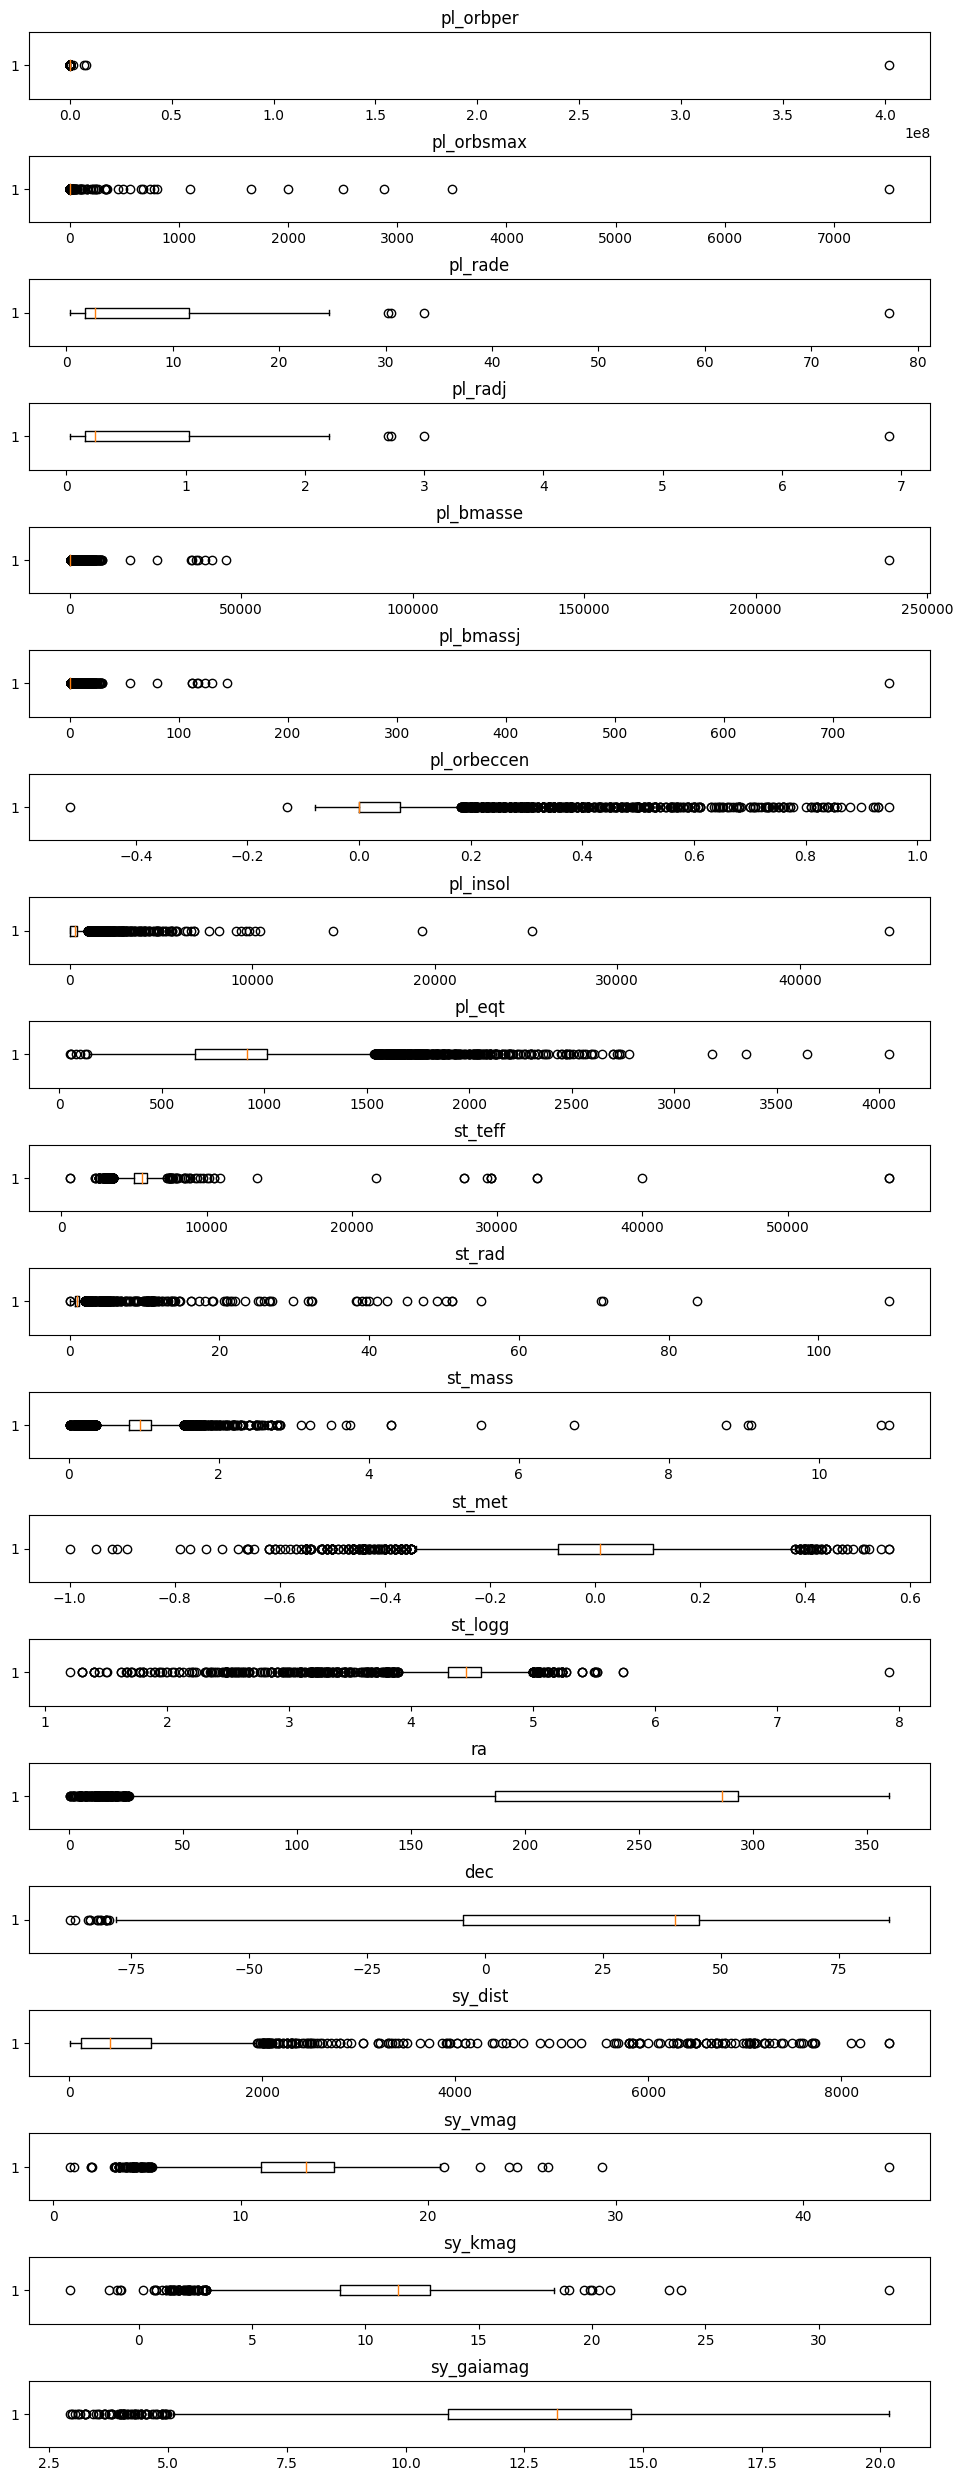

In [41]:
pscd_numerical = pscd_c2.select_dtypes(exclude=['object', 'int64'])
fig, axs = plt.subplots(nrows=len(pscd_numerical.columns), figsize=(10, 25))
fig.tight_layout(pad=2.0)

for i, c in enumerate(pscd_numerical.columns):
    axs[i].boxplot(pscd_numerical[c], vert=False)
    axs[i].set_title(c)

There seems to be some very big outliers in a lot of columns. Let's remove those

In [42]:
pscd_no_outliers = pscd_numerical[(np.abs(stats.zscore(pscd_numerical)) < 3).all(axis=1)]
print(f'Removed {len(pscd_c2) - len(pscd_no_outliers)}/{len(pscd_c2)} rows')

Removed 573/5151 rows


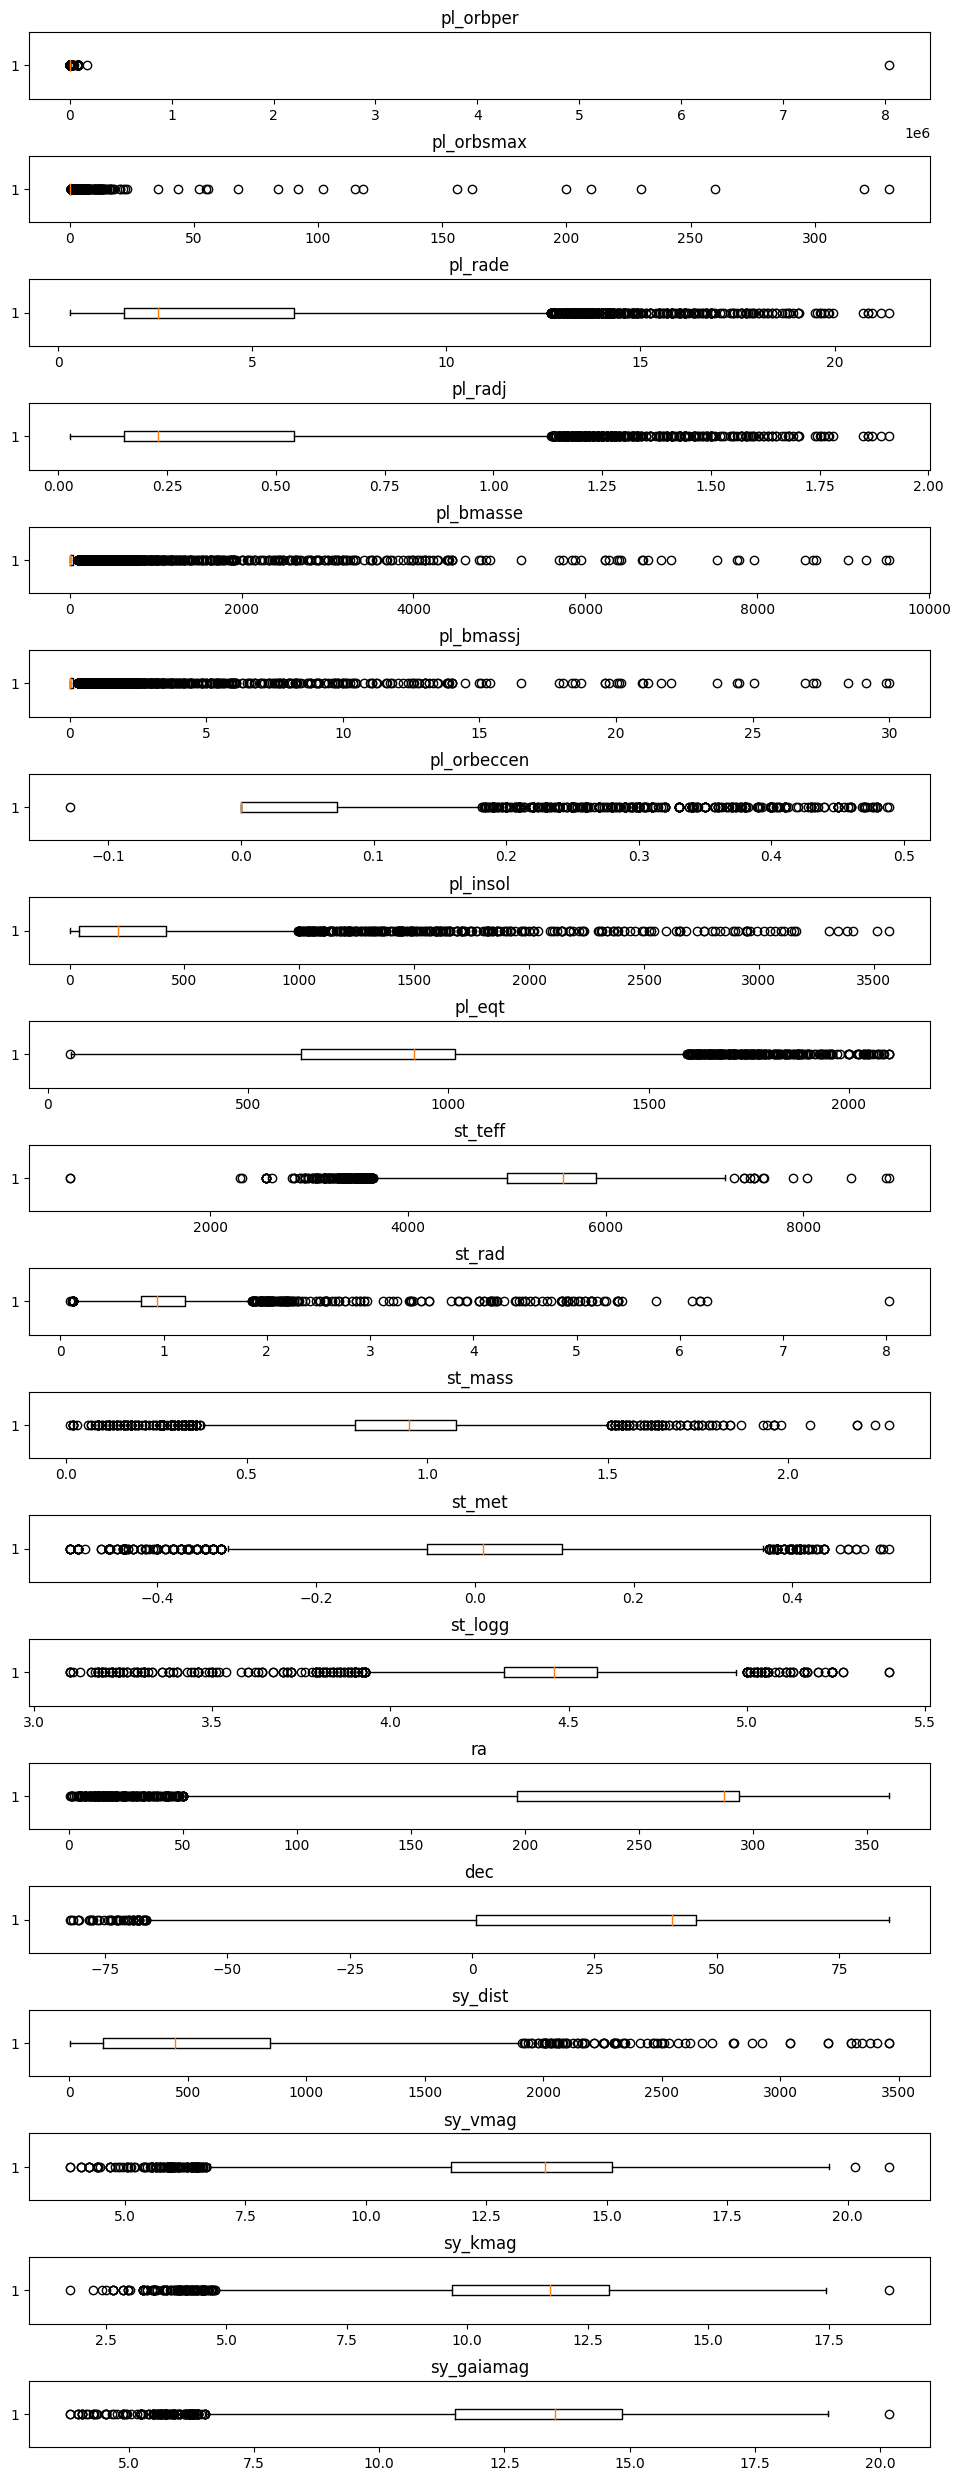

In [43]:
fig, axs = plt.subplots(nrows=len(pscd_no_outliers.columns), figsize=(10, 25))
fig.tight_layout(pad=2.0)

for i, c in enumerate(pscd_no_outliers.columns):
    axs[i].boxplot(pscd_no_outliers[c], vert=False)
    axs[i].set_title(c)

A lot of these are still very skewed

In [44]:
skewed_cols = ['pl_orbper', 'pl_orbsmax', 'pl_bmasse', 'pl_rade', 'pl_eqt', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'st_rad', 'sy_dist']
pscd_log = pscd_c2.copy()

for c in skewed_cols:
    pscd_log[f'{c}_log'] = np.log1p(pscd_log[c])

pscd_log = pscd_log.drop(skewed_cols, axis=1)

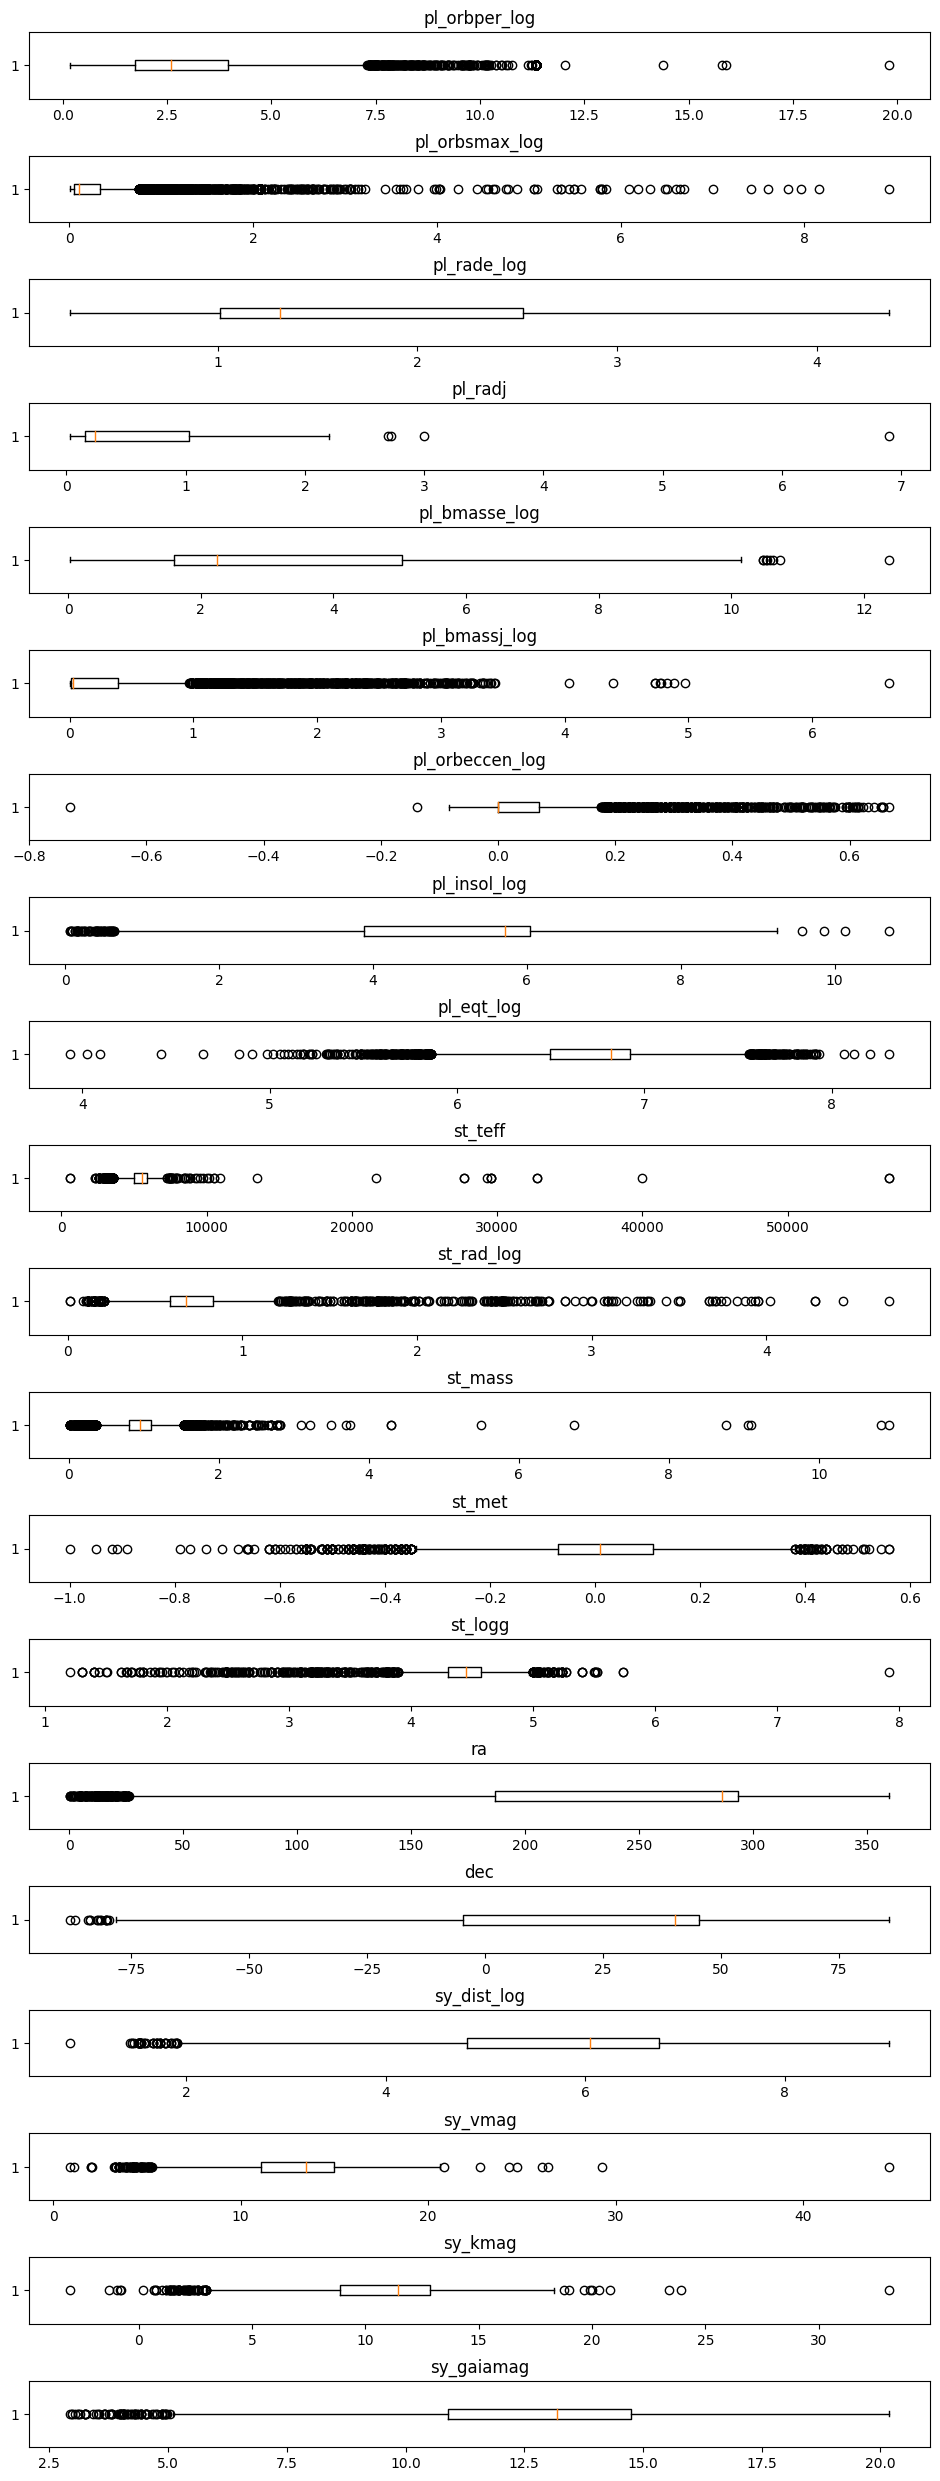

In [45]:
fig, axs = plt.subplots(nrows=len(pscd_numerical.columns), figsize=(10, 25))
fig.tight_layout(pad=2.0)

for i, c in enumerate(pscd_numerical.columns):
    col = c
    if c in skewed_cols:
        col += '_log'
    axs[i].boxplot(pscd_log[col], vert=False)
    axs[i].set_title(col)

Let's add the steps to the pipeline

In [46]:
log_skewed =  FunctionTransformer(Log(columns=skewed_cols))
remove_outliers = FunctionTransformer(RemoveOutliers(4, columns=pscd_numerical.columns))

pscd_pipeline.extend([
    ('Log skewed', log_skewed), 
    ('Remove outliers', remove_outliers)
])

#### Accuracy

Let's keep in mind which columns are uncertain

In [47]:
pscd.columns[pscd.columns.str.contains('err')]

Index(['pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_radeerr1', 'pl_radeerr2', 'pl_radjerr1', 'pl_radjerr2', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqterr1', 'pl_eqterr2', 'st_tefferr1', 'st_tefferr2', 'st_raderr1', 'st_raderr2', 'st_masserr1', 'st_masserr2', 'st_meterr1', 'st_meterr2', 'st_loggerr1', 'st_loggerr2', 'sy_disterr1', 'sy_disterr2', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_kmagerr1', 'sy_kmagerr2', 'sy_gaiamagerr1', 'sy_gaiamagerr2'], dtype='object')

In [48]:
uncertain_columns = list(set(pscd.columns[pscd.columns.str.contains('err')].str.replace('err1', '').str.replace('err2', '')))
pscd_accuracy_info = pscd[uncertain_columns].fillna(0)

for c in uncertain_columns:
    pscd_accuracy_info[f'{c}_sigma'] = pscd[f'{c}err1'] - pscd[f'{c}err2']
    pscd_accuracy_info[f'{c}_sigma_percent'] = pscd_accuracy_info[f'{c}_sigma'] * 100 / np.maximum(pscd_accuracy_info[c], 1)
    print(c)
    print(f'Average sigma: {pscd_accuracy_info[f"{c}_sigma_percent"].mean(): .1f}, std: {pscd_accuracy_info[f"{c}_sigma_percent"].std(): .1f}')
    print(f'Num rows with sigma percent > 20: {len(pscd_accuracy_info[pscd_accuracy_info[f"{c}_sigma_percent"] > 20])}')
    print()

sy_vmag
Average sigma:  1.5, std:  1.6
Num rows with sigma percent > 20: 1

pl_eqt
Average sigma:  7.9, std:  16.8
Num rows with sigma percent > 20: 60

pl_insol
Average sigma:  26.5, std:  34.0
Num rows with sigma percent > 20: 981

pl_orbper
Average sigma:  2.1, std:  18.2
Num rows with sigma percent > 20: 101

sy_kmag
Average sigma:  1.3, std:  9.0
Num rows with sigma percent > 20: 65

sy_gaiamag
Average sigma:  0.0, std:  0.0
Num rows with sigma percent > 20: 0

st_rad
Average sigma:  20.7, std:  113.4
Num rows with sigma percent > 20: 1493

pl_rade
Average sigma:  29.4, std:  122.4
Num rows with sigma percent > 20: 1652

pl_bmasse
Average sigma:  43.5, std:  55.7
Num rows with sigma percent > 20: 1385

pl_orbsmax
Average sigma:  6.9, std:  18.0
Num rows with sigma percent > 20: 214

st_logg
Average sigma:  4.4, std:  4.2
Num rows with sigma percent > 20: 29

st_mass
Average sigma:  14.4, std:  17.4
Num rows with sigma percent > 20: 846

pl_bmassj
Average sigma:  20.1, std:  33.3
N

### Pipeline

In [49]:
from sklearn.pipeline import Pipeline

koi_pipe = Pipeline(koi_pipeline)
koi_clean = koi_pipe.fit_transform(koi)
koi_clean.to_csv('../data/koi_clean.csv')

pscd_pipe = Pipeline(pscd_pipeline)
pscd_clean = pscd_pipe.fit_transform(pscd)
pscd_clean.to_csv('../data/pscd_clean.csv')

## EDA

### Correlation

In [1]:
import seaborn as sns

In [2]:
koi_data_features = koi.columns[~(koi.columns.str.contains('err') | koi.columns.str.contains('lim'))]
corr =  np.round(koi[koi_data_features].corr(), 2)
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

NameError: name 'koi' is not defined

/var/folders/hd/jhkm8wf56773jy80j6900vg00000gn/T/ipykernel_26699/1684545470.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =  np.round(pscd[pscd_data_columns].corr(), 2)


<AxesSubplot: >

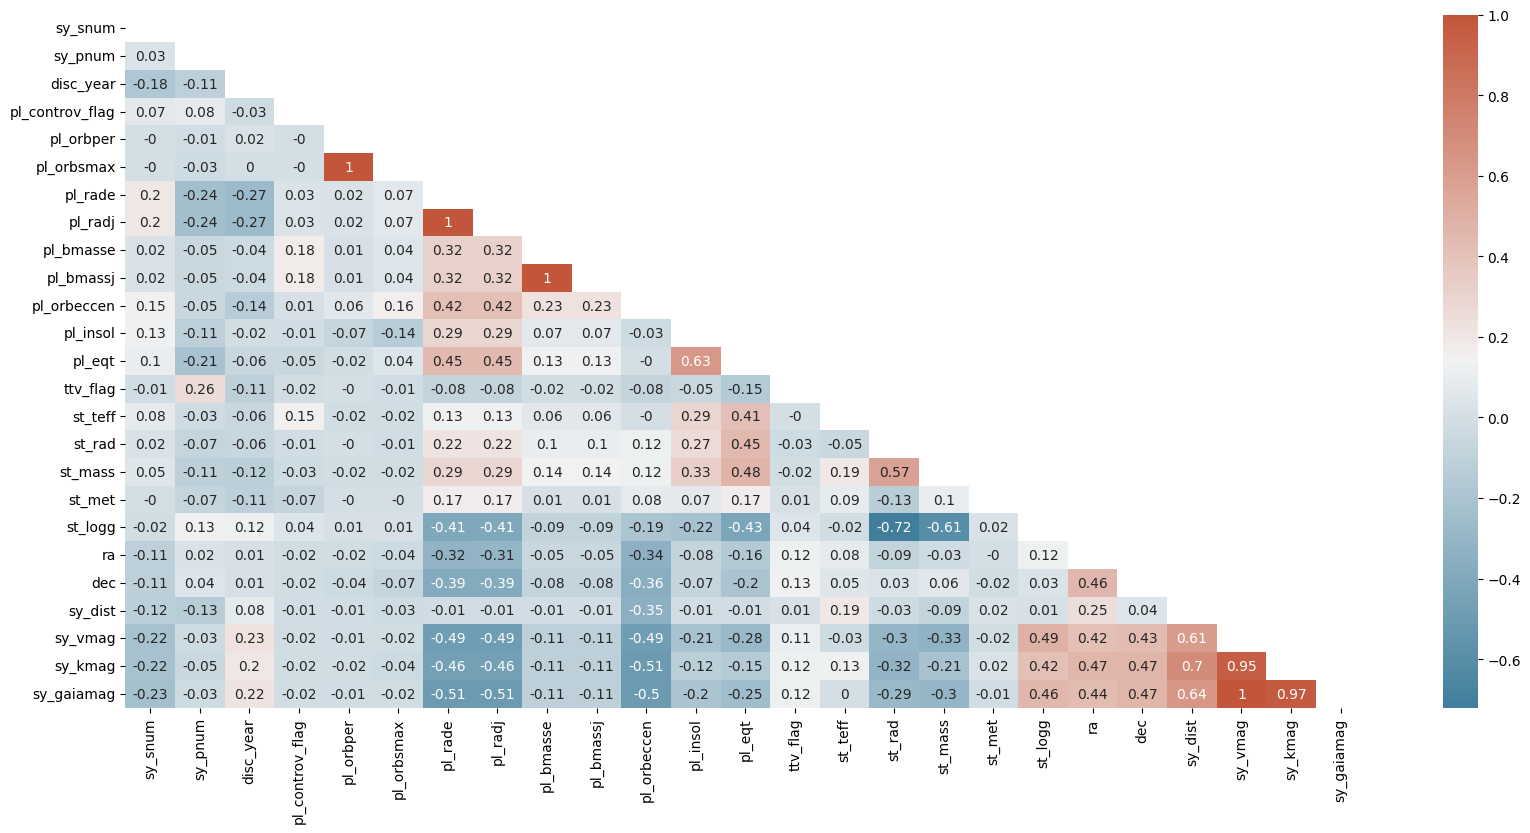

In [ ]:
pscd_data_columns = pscd.columns[~(pscd.columns.str.contains('err') | pscd.columns.str.contains('lim'))]
corr =  np.round(pscd[pscd_data_columns].corr(), 2)
f, ax = plt.subplots(figsize=(20, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

There are quite a lot of correlations here, which does not bode well for linear methods like logistic regression which don't work well for highly correlated variables. 

## Modelling

### Data Preparation

In [ ]:
# From the Kepler dataset, only look at CANDIDATE and CONFIRMED
allowed_dispositions = ['CANDIDATE', 'CONFIRMED']
koi_cc = koi_clean[koi_clean['koi_disposition'].isin(allowed_dispositions)]

In [ ]:
# Only look at data within Keplers FOV
kepler_ra_fov = (koi_cc['ra'].min(), koi_cc['ra'].max())
kepler_dec_fov = (koi_cc['dec'].min(), koi_cc['dec'].max())
pscd_kepler = pscd_clean[(pscd_clean['ra'].between(*kepler_ra_fov)) & (pscd_clean['dec'].between(*kepler_dec_fov))]

We want to only look at the potentially habitable planets from the KOI dataset, following this definition
    - Mass: 0.1-10 Earth mass
    - Radius: 0.5-2.5 Earth radius
    - Eq Temp: 185-270 Kelvin
There is no column that contains the mass, but since the mass is closely related to radius we use the radius as a feature. 

In [ ]:
radius_col = 'koi_prad'
radius_mask = (np.exp(koi_cc[radius_col]) - 1 >= 0.5) & (np.exp(koi_cc[radius_col]) - 1 <= 2.5)
print(f'Radius match: {len(koi_cc[radius_mask]) / len(koi_cc) * 100:.2f}%')


temp_col = 'koi_teq'
temp_mask = (np.exp(koi_cc[temp_col]) - 1 >= 175) & (np.exp(koi_cc[temp_col]) - 1 <= 270)
print(f'Temp match: {len(koi_cc[temp_mask]) / len(koi_cc) * 100:.2f}%')

koi_habitable = koi_cc[temp_mask & radius_mask]
print(f'Total habitable planets found: {len(koi_habitable)}')

Radius match: 65.79%
Temp match: 1.98%
Total habitable planets found: 46


In [ ]:
# To avoid any overlap between the two datasets, we remove any habitable planets from the pscd dataset
radius_col = 'pl_rade'
radius_mask = (np.exp(pscd_kepler[radius_col]) - 1 >= 0.5) & (np.exp(pscd_kepler[radius_col]) - 1 <= 2.5)

temp_col = 'pl_eqt'
temp_mask = (np.exp(pscd_kepler[temp_col]) - 1 >= 175) & (np.exp(pscd_kepler[temp_col]) - 1 <= 270)

pscd_non_habitable = pscd_kepler[~(temp_mask & radius_mask)]
print(f'{len(pscd_kepler[temp_mask & radius_mask])} planets removed')

18 planets removed


In [ ]:
# Separate data into small buckets of 1 RA * 1 DEC size
step_size = 1
num_decimals = 0

ra_round_c = 'ra_round'
dec_round_c = 'dec_round'
koi_habitable[ra_round_c] = koi_habitable['ra'].round(num_decimals)  
koi_habitable[dec_round_c] = koi_habitable['dec'].round(num_decimals)  
pscd_non_habitable[ra_round_c] = pscd_non_habitable['ra'].round(num_decimals)  
pscd_non_habitable[dec_round_c] = pscd_non_habitable['dec'].round(num_decimals)  

ra_min, ra_max = np.round(kepler_ra_fov, num_decimals)
dec_min, dec_max = np.round(kepler_dec_fov, num_decimals)
ra_div = np.arange(ra_min, ra_max + step_size, step_size)
dec_div = np.arange(dec_min, dec_max + step_size, step_size)

compute_grid_place = lambda rra, rdec:  f'{np.where(np.isclose(ra_div, rra))[0][0]},{np.where(np.isclose(dec_div, rdec))[0][0]}'
koi_habitable['grid_place'] = koi_habitable.apply(lambda r: compute_grid_place(r[ra_round_c], r[dec_round_c]), axis=1)
pscd_non_habitable['grid_place'] = pscd_non_habitable.apply(lambda r: compute_grid_place(r[ra_round_c], r[dec_round_c]), axis=1)

### Feature extraction

In [ ]:
# Aggreagate features in the squares
pscd_cols = ['grid_place', 'sy_snum', 'sy_pnum', 'pl_orbper', 'pl_rade', 'pl_bmasse', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met']
X = pscd_non_habitable[pscd_cols].groupby('grid_place').mean()

In [ ]:
# Get which squares contain a potentially habitable  planet
y = X.index.isin(koi_habitable['grid_place'])

In [ ]:
y.sum() / y.shape[0]

0.168

In [ ]:
# Normalize all columns
X_normalized = (X-X.mean())/X.std()

### Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8

### Evaluation

In [ ]:
pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
tn, fp, fn, tp

(40, 0, 10, 0)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.84

In [ ]:
pred = model.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, pred).ravel()
tn, fp, fn, tp

(168, 0, 32, 0)

We observe that the training data has better accuracy than the test data. This indicates that the model is overfitting. 

The confusion matrix shows that we only predict negatively. This causes both metrics precision and recall to be zero which is not ideal. 
However, it could be argued that we do not want non-habitable planets to be considered habitable and we could be fine with classifying habitable planets as non-habitable even though it is not ideal. Therefore, we should avoid false positives. 

To improve our model we could use hyperparameter tuning with the training data to minimize loss function to get better results. In which case, grid search can be used as a hyperparameter tuning method.